<a href="https://colab.research.google.com/github/11051620/2021-2022/blob/main/reference_extraction_v4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1: Setup and Configuration

This notebook implements a multi-agent pipeline using LangGraph to identify and validate historical document references in the 17th-century VOC `Generale Missiven` archives. The core data is accessed directly via the Text-Fabric library.

This initial section handles all necessary setup:
* **Global Flags:** Control the execution mode (e.g., using a real LLM vs. a dummy for testing, enabling LangSmith tracing).
* **Package Installation:** Installs required libraries.
* **Environment Setup:** Configures API keys and endpoints for services like LangSmith.
* **Data Loading:** Mounts Google Drive and loads the Text-Fabric dataset into memory, ensuring it's available for all subsequent steps.

### 1.1: Global Configuration & Constants
This cell contains all the high-level configuration parameters for the notebook. By centralizing these flags, we can easily switch between different execution modes without changing the underlying code.

- **`USE_REAL_LLM`**: Controls whether to use the actual Hugging Face model (requires a GPU) or a dummy function for fast, local testing.
- **`USE_LANGSMITH`**: A master switch to enable or disable automatic tracing with LangSmith. This is useful for saving the trace quota during simple tests.
- **`GDRIVE_TF_DATA_PATH`**: Defines a single, consistent path for storing the Text-Fabric data on Google Drive, ensuring persistence across sessions.

In [ ]:
# --- Execution Flags ---
# Set to True to use the real Hugging Face model (requires GPU).
# Set to False to use the dummy LLM for fast, local testing.
USE_REAL_LLM = True

# Set to True to enable automatic tracing with LangSmith.
# Requires LANGSMITH_API_KEY and HF_TOKEN to be set in Colab Secrets.
USE_LANGSMITH = True

# --- Paths & Constants ---
# Define the persistent path where your Text-Fabric data is stored in your Drive.
GDRIVE_TF_DATA_PATH = "/content/drive/MyDrive/text-fabric-data"

DEBUG_AGENT = True
DEBUG_JSON = True

# --- Info Printout ---
print(f"Running in {'REAL LLM' if USE_REAL_LLM else 'DUMMY'} mode.")
print(f"LangSmith Tracing is {'ENABLED' if USE_LANGSMITH else 'DISABLED'}.")

Running in REAL LLM mode.
LangSmith Tracing is ENABLED.


### 1.2: Package Installation
This cell handles the installation of all required Python libraries. The installations are managed by `pip` and are configured to be "quiet" (`-q`) to keep the notebook output clean. Note that the installation of GPU-specific libraries like `torch` and `bitsandbytes` is conditional and only occurs if `USE_REAL_LLM` is set to `True`, optimizing the setup for different environments.

In [ ]:
print("Installing required packages...")
!pip install -q langgraph langchain langsmith text-fabric

if USE_REAL_LLM:
    !pip install -q torch transformers langchain-huggingface pydantic bitsandbytes
    !pip install -q --upgrade bitsandbytes
print("Installation complete.")


Installing required packages...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

In [ ]:
!pip install -qU langsmith langchain langchain_core

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.6/364.6 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.9/438.9 kB 20.5 MB/s eta 0:00:00


### 1.3: Python Imports & Environment Setup
Here, we import all necessary modules, grouping them by their function (e.g., data handling, LangChain/LangGraph, and Transformers). This section also includes a critical best practice for security: API keys for LangSmith and Hugging Face are loaded from Colab's "Secrets" manager, preventing sensitive credentials from being hardcoded in the notebook. Finally, it conditionally configures the environment variables for LangSmith based on the `USE_LANGSMITH` flag.

In [ ]:
import os
import json
import re
import pprint
from typing import List, Literal, Dict, Optional, Any, TypedDict, get_type_hints
from collections import Counter

# --- Text-Fabric ---
from tf.app import use

# --- Pydantic ---
from pydantic import BaseModel, ValidationError, Field

# --- LangChain & LangGraph ---
from langgraph.pregel import RetryPolicy
from langgraph.graph import StateGraph, END
from langchain.prompts import ChatPromptTemplate, PromptTemplate
from langchain.schema import HumanMessage
from langchain.callbacks.tracers.langchain import LangChainTracer
from langchain_core.tools import tool
from langsmith import Client
from langsmith.run_helpers import traceable

# --- Google Colab & Transformers (Conditional) ---
try:
    from google.colab import userdata, drive
except ImportError:
    print("Not in a Google Colab environment. Skipping Colab-specific imports.")

if USE_REAL_LLM:
    from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, pipeline
    from langchain_huggingface import HuggingFacePipeline
    import torch

# --- Securely Load API Keys ---
# It's highly recommended to store API keys in Colab's "Secrets" manager
# (click the key icon on the left sidebar) instead of hardcoding them.
if USE_LANGSMITH or USE_REAL_LLM:
    try:
        os.environ["LANGSMITH_API_KEY"] = userdata.get('LANGSMITH_API_KEY')
        os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')
        print("Successfully loaded API keys from Colab Secrets.")
    except Exception as e:
        print("Could not load API keys from Colab Secrets. Please set them manually if needed.")
        # You can add manual fallbacks here if necessary, but it's not recommended for sharing.

# --- LangSmith Setup (Conditional) ---
if USE_LANGSMITH:
    print("--- LangSmith Tracing is ENABLED (using V2 protocol) ---")
    os.environ["LANGCHAIN_TRACING_V2"] = "true"
    os.environ["LANGCHAIN_PROJECT"] = "voc_reference_extraction"
    os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
else:
    print("--- LangSmith Tracing is DISABLED ---")
    os.environ["LANGCHAIN_TRACING_V2"] = "false"

Successfully loaded API keys from Colab Secrets.
--- LangSmith Tracing is ENABLED (using V2 protocol) ---


In [ ]:
print("--- Running LangSmith Connection Test ---")

# Check if the key environment variable is set
if os.environ.get("LANGCHAIN_TRACING_V2") != "true":
    print("ERROR: Tracing is not enabled. Please set USE_LANGSMITH = True and re-run your setup cell.")
else:
    try:
        # The Client() automatically reads your environment variables
        # (LANGCHAIN_API_KEY, LANGCHAIN_ENDPOINT)
        client = Client()

        # This command will fail if your API key is invalid or the connection fails.
        projects = client.list_projects()

        print("\n✅ SUCCESS: Connection to LangSmith is working correctly.")
        print("Your script is authenticated and can communicate with the server.")

        # Check if the target project exists
        project_name = os.environ.get("LANGCHAIN_PROJECT")
        project_names = [p.name for p in projects]

        if project_name in project_names:
            print(f"✅ Your project '{project_name}' was found in your LangSmith account.")
        else:
            print(f"⚠️ WARNING: Your project '{project_name}' was NOT found.")
            print("The traces might be going to a default project instead.")
            print("Available projects:", project_names)

    except Exception as e:
        print(f"\n❌ FAILURE: Could not connect to LangSmith.")
        print("This strongly suggests an issue with your API key or endpoint configuration.")
        print(f"Error details: {e}")

--- Running LangSmith Connection Test ---

✅ SUCCESS: Connection to LangSmith is working correctly.
Your script is authenticated and can communicate with the server.
✅ Your project 'voc_reference_extraction' was found in your LangSmith account.


### 1.4: Data Loading via Local Repository Clone
This final setup step initializes the connection to our primary data source, the Text-Fabric `Generale Missiven` dataset. The process uses a robust `git clone` strategy to ensure persistence, speed, and offline capability within the Colab environment.
1.  **Mount Google Drive:** Connects the notebook to the user's Google Drive.
2.  **Clone Repository (First Run Only)**: On the very first run, it clones the entire `wp6-missieven` GitHub repository into a specific folder structure (`text-fabric-data/github/CLARIAH/`) on your Google Drive.
3.  **Create Symbolic Link:** It creates a "shortcut" from the Colab session's temporary home directory to your persistent Google Drive folder. This is a critical step that allows Text-Fabric to find the local data correctly.
4. **Load Data from Clone**: The `tf.app.use()` function is instructed to load the data from the local clone, bypassing any network checks. After a one-time pre-computation, all subsequent loads will be very fast.



In [ ]:
# 1. Mount Google Drive
# This is required at the start of every new session to access persistent storage.
print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Drive mounted successfully.")

# 2. Define the root directory for all Text-Fabric data on your Drive
GDRIVE_TF_ROOT = "/content/drive/MyDrive/text-fabric-data"

# 3. Define the full, correct path where the cloned repository must live
# to match the structure that Text-Fabric expects.
LOCAL_REPO_PATH = os.path.join(GDRIVE_TF_ROOT, "github", "CLARIAH", "wp6-missieven")

# 4. Clone the repository into the correct structure on Drive (only if it doesn't already exist)
if not os.path.exists(LOCAL_REPO_PATH):
    print(f"Local repository not found. Cloning into {LOCAL_REPO_PATH}...")
    # Create all necessary parent directories (e.g., github/CLARIAH)
    os.makedirs(os.path.dirname(LOCAL_REPO_PATH), exist_ok=True)
    # Use git to clone the repository directly into the final target path
    !git clone https://github.com/CLARIAH/wp6-missieven.git {LOCAL_REPO_PATH}
    print("Repository cloned successfully.")
else:
    print(f"Repository already exists at {LOCAL_REPO_PATH}.")

# 5. Create a symbolic link from the default TF directory (~/github) to our Google Drive.
# This makes Colab's temporary home directory point to our persistent storage.
TF_DEFAULT_PATH = os.path.expanduser("~/github")
if not os.path.exists(TF_DEFAULT_PATH):
    # Link the 'github' folder in our Drive to the location TF expects
    !ln -s {os.path.join(GDRIVE_TF_ROOT, "github")} {os.path.expanduser("~")}
    print(f"Symbolic link created from {TF_DEFAULT_PATH} to your Google Drive.")

# 6. Load Text-Fabric from the local clone via the symbolic link.
# We call use() without the `dataDir` argument, as it will now look in the
# default path (~/github), be redirected by our link, and find the local data.
print("Loading Text-Fabric data from local clone...")
A = use(
    "CLARIAH/wp6-missieven",
    hoist=globals(),
    checkout="clone",
    silent=True
)
print("Text-Fabric data loaded successfully.")

Mounting Google Drive...
Mounted at /content/drive
Drive mounted successfully.
Repository already exists at /content/drive/MyDrive/text-fabric-data/github/CLARIAH/wp6-missieven.
Symbolic link created from /root/github to your Google Drive.
Loading Text-Fabric data from local clone...
**Locating corpus resources ...**
Text-Fabric data loaded successfully.


##2: Data Ontology and Schemas

This project uses a schema-driven approach for maximum reliability and clarity. While an **ontology** defines the concepts and relationships we want to model (the "what"), a **schema** provides the strict technical structure for storing that information (the "how"). This project uses both: we define a clear ontology for document references and implement it with strict Pydantic schemas.

This approach provides three key benefits:
* **Reliability:** Any LLM output that does not conform to the required schema is automatically invalid, preventing malformed data from propagating through the pipeline.
* **Clarity:** The schemas act as a single source of truth for the data structure, making the code easier to understand and maintain.
* **Flexibility:** To experiment with extracting new information, you only need to update the schema here; the rest of the pipeline adapts automatically.

This section defines the core data structures used throughout the pipeline.

### 2.1: The Extraction Ontology & Schema (`DocumentReferenceExtraction`)
This is the core of our data model. It defines the "target" information we want the primary LLM agent to extract for every potential document reference. It specifies not only the fields to be extracted but also the chain-of-thought the agent must follow, with the `reasoning` and `reference_type` fields capturing the nuanced analysis of the text.

In [ ]:
class ReferencedEntity(BaseModel):
    type: str = Field(..., description="Entity type, e.g., 'Person', 'Date', 'Location', 'Organization'")
    value: str = Field(..., description="The value of the entity, e.g., a name or date")
    role: Optional[str] = Field(None, description="Role of the entity relative to the document, e.g., 'Sender', 'Recipient'")
    text: Optional[str] = Field(None, description="The exact text from which the entity was extracted")
    confidence: Optional[float] = Field(None, description="Confidence score (0 to 1) for this entity extraction")

class DocumentReferenceExtraction(BaseModel):
    """
    Schema for extracting a single potential document reference from a text.
    The model should generate its reasoning first, then make its final classifications.
    """
    reference_text: str = Field(..., description="The exact text span identified as the reference")
    # Reasoning comes before the final decision
    reasoning: str = Field(..., description="A concise, multi-line string containing your chain-of-thought analysis (literal, contextual, and classification steps).")
    reference_type: Optional[Literal[
        "direct_mention",
        "anaphoric_mention",
        "self_reference",
        "generic_use"
    ]] = Field(None, description="The contextual function of the reference, if validated.")

    # Decisions are made after reasoning
    status: str = Field(..., description="Based on your reasoning, classify the processing status: 'validated', 'rejected', or 'potential'.")
    overall_confidence: Optional[float] = Field(None, description="Based on your reasoning, what is your overall confidence (0-1) that this is a valid reference?")
    referenced_document_type: Optional[str] = Field(None, description="If validated, classify the type of the referenced document (e.g., 'missive', 'ordre', 'rapport').")
    referenced_document_type_confidence: Optional[float] = Field(None, description="Confidence (0-1) in the document type classification.")
    #referenced_entities: Optional[List[ReferencedEntity]] = Field(default_factory=list, description="List of entities extracted from the context relevant to the reference.")
    ghost_document: Optional[bool] = Field(None, description="True if your reasoning suggests the referenced document does not exist or is lost.")


### 2.2: The Judge's Decision Schema (`JudgeDecision`)
This schema structures the output of our LLM-as-a-Judge agent. When multiple interpretations are extracted for a single reference, the judge is invoked. This model ensures that the judge's comparative analysis (`justification`), its final choice (`best_output_index`), and its confidence are captured in a consistent, predictable format.

In [ ]:
class JudgeDecision(BaseModel):
    """
    Schema for the Judge's decision after comparing multiple extraction outputs.
    """
    justification: str = Field(..., description="A concise explanation for why this output was chosen as the best.")
    best_output_index: int = Field(..., description="The 0-based index of the winning JSON object from the provided list.")
    confidence_score: float = Field(..., description="The judge's confidence in its decision, from 0.0 to 1.0.")


### 2.3: The Pipeline State Schema (`ValidationState`)
This `TypedDict` defines the "memory" of our graph. It is the central object that is passed between all the nodes in our pipeline. It starts simple, containing just the initial `match_node`, and is progressively populated with data (e.g., `paragraph_text`, `extracted_outputs`, `final_output`) as the agents complete their tasks. It also contains control-flow fields like `retry_count` and `error` to manage the pipeline's execution.

In [ ]:
class ValidationState(TypedDict):
    """
    The starting state for our validation pipeline. It starts simple and gets
    populated as the graph runs.
    """
    # --- Primary Input ---
    match_node: int # The only input required to start a run

    # --- Data Letter Populated by reference_validator ---
    paragraph_text: Optional[str]
    author: Optional[str]
    date: Optional[str]
    place: Optional[str]
    title: Optional[str]

    # --- Extractor Output ---
    extracted_outputs: List[DocumentReferenceExtraction]

    # --- Final Outputs After Judging/Processing ---
    final_output: Optional[DocumentReferenceExtraction]
    judge_decision: Optional[JudgeDecision]
    needs_review: bool

    # --- Control Flow ---
    error: Optional[str]
    retry_count: int

### 2.4: Schema-to-Prompt Utility
This helper function is a crucial bridge between our Python code and the LLM. It introspects any Pydantic schema and automatically generates a human-readable, descriptive list of fields. This string is then injected directly into our prompt templates. This ensures that the LLM's instructions are always perfectly synchronized with the validation schema, automating a key part of prompt engineering and reducing the risk of errors.

In [ ]:
def schema_json_instruction_with_desc(schema_cls):
    # Get human-readable type names for all fields
    type_hints = get_type_hints(schema_cls, include_extras=True)
    lines = []
    for field_name, model_field in schema_cls.model_fields.items():
        # Use type hints for simple names
        hint = type_hints[field_name]
        # For generics like Optional[str], this gives typing.Optional[str], so we get the underlying type
        origin = getattr(hint, '__origin__', None)
        if origin is not None and origin is not list and origin is not dict:
            # typing.Optional[X] or typing.Union[X, NoneType]
            args = hint.__args__
            type_str = args[0].__name__ if hasattr(args[0], '__name__') else str(args[0])
        elif hasattr(hint, '__name__'):
            type_str = hint.__name__
        else:
            type_str = str(hint).replace('typing.', '')

        desc = model_field.description or ""
        # Only mark (optional) if is_required() is False
        opt_str = " (optional)" if not model_field.is_required() else ""
        lines.append(f"- '{field_name}' ({type_str}){opt_str}: {desc}")
    fields_list = "\n".join(lines)
    return (
        f"{fields_list}"
    )

def schema_json_instruction_for_specific_fields(schema_cls, field_names: List[str]):
    """
    Creates a CONCISE instruction string from a Pydantic schema, but only for
    the fields specified in the `field_names` list.
    """
    type_hints = get_type_hints(schema_cls, include_extras=True)
    lines = []

    # Loop through only the field names you want to include
    for field_name in field_names:
        if field_name not in schema_cls.model_fields:
            continue # Skip if the field name isn't in the schema

        model_field = schema_cls.model_fields[field_name]
        hint = type_hints[field_name]

        # This logic for getting the type string is the same as before
        origin = getattr(hint, '__origin__', None)
        if origin is not None and origin is not list and origin is not dict:
            args = hint.__args__
            type_str = args[0].__name__ if hasattr(args[0], '__name__') else str(args[0])
        elif hasattr(hint, '__name__'):
            type_str = hint.__name__
        else:
            type_str = str(hint).replace('typing.', '')

        opt_str = " (optional)" if not model_field.is_required() else ""
        # We only include the field name and type, no description.
        lines.append(f"- '{field_name}' ({type_str}){opt_str}")

    fields_list = "\n".join(lines)
    return fields_list

## 3: Core Components: Prompts, Builders, and Parsers

This section contains the "brains" of the operation: the carefully engineered instructions given to the LLM and the utility functions that prepare those instructions and parse the results. A well-designed set of prompts and utilities is critical for ensuring the reliability and consistency of any LLM-powered system.

This section is divided into three key areas:
- **Prompt Templates:** The static, version-controlled instructions that define the LLM's tasks.
- **Prompt Builders:** The dynamic functions that populate these templates with data from the pipeline's current state.
- **Parsers and Utilities:** The robust functions that clean and validate the LLM's potentially messy raw output.

### 3.1: Prompt Templates
These `ChatPromptTemplate` objects from LangChain define the detailed instructions for our LLM agents. By treating prompts as structured templates, we can ensure that every agent call is consistent and follows the same rigorous methodology.

We define three specialized templates:
- **`reference_validation_template`**: The standard prompt for the initial extraction attempt. It guides the LLM through a detailed chain of thought.
- **`reference_validation_retry_template`**: A more concise and forceful version used for retry attempts. It prioritizes getting a parsable JSON output when the first attempt fails.
- **`judge_template`**: The prompt for our LLM-as-a-Judge, instructing it to perform a detailed comparative analysis between two candidate extractions.


---



> ### **Future Implementation Note: Prompt Management with LangChain Hub**
A more advanced and robust way to manage these prompts is to store them in the **LangChain Hub** (part of the LangSmith platform). This approach decouples the prompts from the application code and offers several key advantages:
*   **Versioning and Centralization**: Prompts are version-controlled in a central repository, making it easy to track changes and roll back if needed.
*   **Collaboration**: A subject matter expert could edit and improve the prompts in the user-friendly LangSmith UI without ever needing to modify the Python code.
*   **Code Simplicity**: Instead of defining the long templates here, we could pull the most up-to-date version with a single line of code, like `hub.pull("your-username/your-prompt-name")`.





In [ ]:
# First, create the dynamic instruction string from the Pydantic schema.
# This ensures the LLM's instructions are always perfectly in sync with our data validation model.
output_instruction = schema_json_instruction_with_desc(DocumentReferenceExtraction)
judge_schema_instruction = schema_json_instruction_with_desc(JudgeDecision)

# Template 1: The standard prompt for the primary reference extraction agent.
# This detailed prompt guides the LLM through a multi-step chain of thought.
reference_validation_template = ChatPromptTemplate.from_messages([
    ("system",
     "### Persona\n"
     "You are an expert historian specializing in identifying references to other documents within 17th-century Dutch VOC archives. You are meticulous, evidence-based, and precise.\n\n"
     "### Core Task\n"
     "You will analyze paragraphs from letters found in the 'Generale Missiven', a 13-volume collection of annual general reports sent from the VOC Governor-General and Council in Asia to the 'Heren Zeventien' (the board of directors) in the Netherlands between 1610-1761. These letters provide a continuous overview of VOC activities and often summarize reports received from various settlements.\n\n"
     "Your task is to identify if a highlighted term in a paragraph is a reference to a separate, distinct document (e.g., another letter, a specific report, an order, a decree). Analyze the full context for clues.\n\n"
     "- The reference can be to any document (also other letters in the 'Generale Missiven'), including those now lost ('ghost' documents), as long as the context implies it is a distinct item.\n"
     "- Analyze the full context and paragraph for clues like dates, sender/recipient, or verbs like 'copying' or 'see'. Do not rely on keywords alone.\n\n"
     "### Instructions\n"
     "1.  First, in the `reasoning` field, compose your analysis as a **concise, single, multi-line string**. Focus on the key evidence and follow the chain of thought (literal analysis, contextual inference, and classification).\n"
     "2.  **Second, based ONLY on the reasoning you just wrote**, fill out all other fields in the JSON object. Do not re-read the source paragraph to make these final decisions.\n\n"
     "### Reference Type Definitions (Only for validated references)\n"
     "- `direct_mention`: The term introduces a specific document for the first time.\n"
     "- `anaphoric_mention`: The term refers back to a document just introduced in the immediate context.\n"
     "- `self_reference`: The term refers to the *current* document being analyzed. This should be 'rejected'.\n"
     "- `generic_use`: The term is used in an abstract or general sense. This should be 'rejected'.\n\n"

     "You must provide your response as a single, valid JSON object. Do not include any text, explanation, or markdown formatting before or after the JSON object(no preamble, no follow-up, and no explanation outside JSON).\n"
     "The JSON object must contain the following fields (unless the field is stated as 'optional'):\n"
     "{output_instruction}\n"
    ),
    ("user",
     "Please review the following case for a potential document reference.\n\n"
     "**Database ID:** {database_identifier}\n\n"
     "**Letter Metadata:**\n"
     "  - Author: {author}\n"
     "  - Date: {date}\n"
     "  - Place: {place}\n"
     "  - Title: {title}\n\n"
     "**Paragraph with Highlighted Term:**\n"
     "```\n"
     "{paragraph_text}\n"
     "```\n\n"
     "Analyze this case following all instructions and provide your findings as a single JSON object."
    )
])


# Template 2: A more forceful and concise prompt used for retry attempts.
# This helps break the LLM out of a failure loop if it was too verbose on the first try.
reference_validation_retry_template = ChatPromptTemplate.from_messages([
    ("system",
     "### Persona\n"
     "You are an expert historian specializing in 17th-century Dutch VOC archives. You are meticulous, evidence-based, and precise.\n\n"
     "### Core Task\n"
     "You will analyze a paragraph from a letter found in the 'Generale Missiven'. Your task is to identify if a highlighted term refers to a separate, distinct document.\n\n"
     "### Instructions\n"
     "**ATTENTION: A previous attempt to generate a JSON for this case failed, likely due to an overly long 'reasoning' field. Your new priority is to be EXTREMELY CONCISE.**\n\n"
     "1.  In the `reasoning` field, provide only the most critical, evidence-based points in as few words as possible. Follow the chain of thought but be brief.\n"
     "2.  Based ONLY on your concise reasoning, fill out all other fields.\n\n"
     "### Reference Type Definitions (Only for validated references)\n"
     "- `direct_mention`: The term introduces a specific document for the first time.\n"
     "- `anaphoric_mention`: The term refers back to a document just introduced.\n"
     "- `self_reference`: The term refers to the *current* document being analyzed (should be 'rejected').\n"
     "- `generic_use`: The term is used in an abstract sense (should be 'rejected').\n\n"
     "### Output Format & Example\n"
     "You must provide your response as a single, valid JSON object and nothing else. Follow the format in this example precisely.\n\n"
     "**EXAMPLE of a PERFECT CONCISE OUTPUT:**\n"
     "```json\n"
     "{{\n"
     "  \"reference_text\": \"de missive van den gouverneur\",\n"
     "  \"reasoning\": \"Literal: Mentions 'de missive van den gouverneur'.\\nInference: This is a distinct document reference.\\nType: It is a 'direct_mention'.\",\n"
     "  \"reference_type\": \"direct_mention\",\n"
     "  \"status\": \"validated\",\n"
     "  \"overall_confidence\": 0.95\n"
     "}}\n"
     "```\n\n"
     "The JSON object you create must contain the fields stated here above and again listed and described here:\n\n"
     "{output_instruction}\n"

    ),
    ("user",
     "Please review the following case for a potential document reference.\n\n"
     "**Database ID:** {database_identifier}\n\n"
     "**Letter Metadata:**\n"
     "  - Author: {author}\n"
     "  - Date: {date}\n"
     "  - Place: {place}\n"
     "  - Title: {title}\n\n"
     "**Paragraph with Highlighted Term:**\n"
     "```\n"
     "{paragraph_text}\n"
     "```\n\n"
     "Analyze this case following all instructions and provide your findings as a single, concise JSON object."
    )
])

# Template 3: The prompt for the LLM-as-a-Judge agent.
# It defines the criteria for a high-quality analysis and instructs the model
# to perform a comparative evaluation.
judge_template = ChatPromptTemplate.from_messages([
    ("system",
     "### Persona\n"
     "You are an impartial Chief Historian acting as a judge. You are reviewing multiple analysis attempts, submitted as JSON objects, from a junior historian. These attempts all concern the SAME highlighted term in a source text.\n\n"
     "### Core Task\n"
     "Your task is to critically evaluate and compare the candidate JSON outputs to select the single BEST analysis. You are not just choosing the most common answer; you are selecting the highest quality interpretation based on logical rigor and evidence.\n\n"
     "### Evaluation Criteria\n"
     "Compare the candidate JSON objects based on the following criteria:\n"
     "1.  **Reasoning Quality:** This is the most important criterion. Is the `reasoning` logical, well-supported by evidence from the text, and comprehensive? Does it correctly justify the final `status`?\n"
     "2.  **Reference Text Precision:** Is the `reference_text` span captured precisely, without missing words or including extraneous context?\n"
     "3.  **Status and Confidence Accuracy:** Do the `status` and `overall_confidence` fields accurately reflect the strength of the evidence presented in the `reasoning` field?\n"
     "4.  **Completeness and Detail:** Did the agent correctly identify the `referenced_document_type` and any `referenced_entities` where applicable? A more detailed and accurate analysis is superior.\n\n"
     "### Instructions\n"
     "1.  Review the source text and all candidate JSON analyses provided.\n"
     "2.  **Generate Justification First:** In the `justification` field, write a detailed comparative analysis. Explicitly compare the candidates against the evaluation criteria, highlighting the strengths and weaknesses of each. Conclude this justification by stating which output is superior.\n"
     "3.  **Derive Decision from Justification:** Based ONLY on the reasoning you just wrote in the `justification` field, determine the `best_output_index` and your `confidence_score`.\n\n"
     "### Output Format\n"
     "You must provide your response as a single, valid JSON object. Do not include any text, explanation, or markdown formatting before or after the JSON object.\n"
     "The JSON object must contain the following fields:\n"
     "{judge_schema_instruction}"
    ),
    ("user",
     "Please judge the following analyses for the case with **Database ID: {database_identifier}**.\n\n"
     "**Source Paragraph with Highlighted Term:**\n"
     "```\n"
     "{paragraph_text}\n"
     "```\n\n"
     "**Candidate JSON Outputs:**\n"
     "```json\n"
     "{candidate_outputs_json}\n"
     "```\n\n"
     "Analyze these candidates following all instructions and provide your judgment as a single JSON object."
    )
])




### 3.2: Prompt Builders
These helper functions act as the bridge between the pipeline's dynamic `ValidationState` and the static `ChatPromptTemplate`s. Each function is responsible for taking the current state and correctly formatting it into the variables required by its corresponding template. This modular approach keeps the agent logic clean and separates the task of data formatting from the task of agent execution.

In [ ]:
def build_reference_validation_messages(state: ValidationState, output_instruction: str):
    """
    Builds the prompt for the standard extraction attempt by reading
    all necessary data directly from the state dictionary.
    """
    # All variables are now sourced safely from the state dictionary using .get()
    return reference_validation_template.format_messages(
        database_identifier=state.get('database_identifier', 'N/A'),
        author=state.get('author', ''),
        date=state.get('date', ''),
        place=state.get('place', ''),
        title=state.get('title', ''),
        paragraph_text=state.get('paragraph_text', ''),
        output_instruction=output_instruction
    )

def build_reference_validation_retry_messages(state: ValidationState, output_instruction: str):
    """Builds the prompt for a RETRY attempt, using .get() for safety."""
    # This function is identical to the standard builder but uses the retry template.
    return reference_validation_retry_template.format_messages(
        database_identifier=state.get('database_identifier', 'N/A'),
        author=state.get('author', ''),
        date=state.get('date', ''),
        place=state.get('place', ''),
        title=state.get('title', ''),
        paragraph_text=state.get('paragraph_text', ''),
        output_instruction=output_instruction
    )

def build_judge_messages(state: ValidationState, candidate_outputs: List[Dict], judge_schema_instruction: str) -> List:
    """
    Builds the messages for the LLM-as-a-Judge agent.
    This version now takes the state dictionary for consistency.
    """
    # Convert the list of dicts into a pretty-printed JSON string for the prompt
    candidate_outputs_json = json.dumps(candidate_outputs, ensure_ascii=False, indent=2)

    messages = judge_template.format_messages(
        database_identifier=state.get('database_identifier', 'N/A'),
        paragraph_text=state.get('paragraph_text', ''),
        candidate_outputs_json=candidate_outputs_json,
        judge_schema_instruction=judge_schema_instruction
    )
    return messages

### 3.3: Parsers and Utilities
This section contains robust utility functions designed to handle the often-unpredictable nature of LLM text generation. They ensure that the data passed to the downstream agents is clean, validated, and structured.

- **`extract_all_json_extractions`**: This crucial function uses a brace-balancing parser (more robust than regex) to find and validate every single JSON object in the LLM's raw output against our Pydantic schemas.
- **`deduplicate_extractions`**: This function intelligently removes functionally identical extraction candidates before they are sent to the judge. This prevents the judge from getting stuck on trivial comparisons and makes the pipeline more efficient.

In [ ]:
def extract_all_json_extractions(text: str, schema_cls) -> List[BaseModel]:
    """
    Extracts and validates all JSON objects from a string, even if there are multiple.
    This version uses a brace-balancing parser instead of regex for robustness.

    Args:
        text (str): The raw text output from the LLM.
        schema_cls: The Pydantic class to validate against (e.g., DocumentReferenceExtraction).

    Returns:
        A list of validated Pydantic schema instances.
    """
    extractions = []
    search_pos = 0
    while search_pos < len(text):
        # Find the start of the next potential JSON object
        try:
            start_brace = text.index('{', search_pos)
        except ValueError:
            break # No more '{' found in the rest of the string

        brace_level = 1
        # Find the corresponding closing brace for the object
        for i in range(start_brace + 1, len(text)):
            char = text[i]
            if char == '{':
                brace_level += 1
            elif char == '}':
                brace_level -= 1
                if brace_level == 0:
                    # We've found a complete JSON object string
                    json_candidate = text[start_brace : i + 1]
                    try:
                        obj = json.loads(json_candidate)
                        validated_obj = schema_cls.model_validate(obj)
                        extractions.append(validated_obj)
                        if DEBUG_JSON:
                            ref_text_info = f" | Ref text: {validated_obj.reference_text}" if hasattr(validated_obj, 'reference_text') else ""
                            print(f"[parser] Validated a '{schema_cls.__name__}' object{ref_text_info}")
                    except (json.JSONDecodeError, ValidationError) as e:
                        if DEBUG_JSON:
                            print(f"[parser] Skipped invalid JSON candidate. Reason: {e}")
                    # Move search position past the object we just processed
                    search_pos = i + 1
                    break
        else:
            # If the inner loop finishes without finding a closing brace, stop searching
            break

    if DEBUG_JSON:
        print(f"[parser] Total valid extractions: {len(extractions)}")
    return extractions


def deduplicate_extractions(extractions: List[DocumentReferenceExtraction]) -> List[DocumentReferenceExtraction]:
    """
    Filters a list of DocumentReferenceExtraction objects to remove functional duplicates.
    Duplicates are identified by a "signature" composed of key fields, excluding 'reasoning'.
    """
    seen_signatures = set()
    deduplicated_list = []

    # The fields used to create a unique "signature" for each extraction.
    # 'reasoning' is deliberately excluded to catch duplicates with minor wording changes.
    signature_fields = [
        'reference_text',
        'status',
        'overall_confidence',
        'referenced_document_type',
        'referenced_document_type_confidence',
        'ghost_document'
    ]

    for extraction in extractions:
        # A tuple is used for the signature because it is hashable and can be stored in a set.
        signature = tuple(getattr(extraction, field) for field in signature_fields)

        if signature not in seen_signatures:
            seen_signatures.add(signature)
            deduplicated_list.append(extraction)
        else:
            if DEBUG_AGENT:
                print(f"[deduplicator] Found and removed a duplicate extraction for: {extraction.reference_text}")

    if DEBUG_AGENT and len(extractions) > len(deduplicated_list):
        print(f"[deduplicator] Deduplication complete. Reduced {len(extractions)} candidates to {len(deduplicated_list)}.")

    return deduplicated_list


def display_json(obj):
    """A simple helper function to pretty-print JSON for debugging."""
    print(json.dumps(obj, indent=2, ensure_ascii=False))

## 4: The Agentic Pipeline: Nodes and Graph

This section defines the agents (as Python functions) and wires them together into a state machine, or "graph," using LangGraph. This agentic workflow allows for complex, multi-step reasoning where different specialized agents can collaborate to solve a problem.

### The Agents (Nodes)
- **LLM Wrappers:** Selects between a real Hugging Face model and a dummy function for testing.
- **`reference_validator`**: The primary agent. It receives a `match_node` from Text-Fabric, fetches all necessary context and metadata, builds a prompt, calls the LLM, and parses the response.
- **`process_single_candidate`**: An "express path" that validates high-confidence results without needing the judge.
- **`judge_node`**: The LLM-as-a-Judge. It orchestrates a bias-mitigated tournament between multiple LLM outputs to select the best one.
- **Retry & Error Handlers**: Nodes that manage the retry loop and handle any failures gracefully.

### The Graph
The nodes are connected by "edges" that direct the flow of data. Conditional edges, controlled by the `should_judge` function, create intelligent routing based on the output of the extractor node (e.g., routing to the judge, retrying, or finishing).

>### Future Implementations
This robust graph structure makes it easy to add more capabilities in the future:
* **Enhanced Error Handling:** A `RetryPolicy` could be added to the extractor node to automatically handle transient API or network failures, complementing our existing semantic retry loop.
* **Parallel Execution:** For cases with many extraction candidates, the `judge_node`'s tournament could be parallelized using LangGraph's `.map()` functionality to significantly speed up the judging process.
* **Human-in-the-Loop:** For cases that are flagged for `needs_review`, we could implement a true Human-in-the-Loop workflow. The graph could be configured to pause, wait for human input or correction via an interface, and then resume the run with that verified data.
* **Extending the Agent System:**
    - **Ensemble of Extractors:** Instead of one extractor agent, we could run multiple different agents (or the same agent with different prompts) in parallel. The `judge_node` would then select the best output from a diverse set of initial candidates, increasing robustness.
    - **Tool-Using Agents:** The agents could be given "tools" to query the structured GLOBALISE datasets directly. For example, upon extracting a place name, an agent could use a tool to query the gazetteer dataset to verify its existence and fetch its coordinates, making the final output more factually grounded.

### 4.1: LLM Wrappers
This block defines the functions that wrap our language models. This approach allows us to easily switch between a powerful, real LLM for production runs and a simple, predictable `dummy_llm` for fast, offline testing and debugging of the pipeline's logic. All subsequent code interacts with the model through the unified `llm` variable.

In [ ]:
def dummy_llm(prompt: str):
    """
    A dummy LLM to simulate the pipeline for testing without a GPU.
    - For an extractor prompt, it returns a fixed string with multiple candidate JSONs.
    - For a judge prompt, it deterministically picks the 'best' candidate.
    """
    # --- Unique identifiers for each candidate's reasoning ---
    reasoning_c1_good = "This is a good, detailed reasoning."
    reasoning_c2_bad = "This reasoning is brief and lacks detail."
    reasoning_c3_best = "This is the most comprehensive and well-supported reasoning."

    # ---- Simulate the Judge Agent ----
    if "critically evaluate and compare" in prompt:
        # Determine which candidates are being compared
        is_c1_present = reasoning_c1_good in prompt
        is_c2_present = reasoning_c2_bad in prompt
        is_c3_present = reasoning_c3_best in prompt

        # Default to a safe choice
        best_index = 0

        # Scenario: C1 (Good) vs C2 (Bad)
        if is_c1_present and is_c2_present:
            # Always pick C1
            if prompt.find(reasoning_c1_good) < prompt.find(reasoning_c2_bad):
                best_index = 0  # C1 is at index 0
            else:
                best_index = 1  # C1 is at index 1

        # Scenario: C1 (Good) vs C3 (Best)
        elif is_c1_present and is_c3_present:
            # Always pick C3
            if prompt.find(reasoning_c3_best) < prompt.find(reasoning_c1_good):
                best_index = 0  # C3 is at index 0
            else:
                best_index = 1  # C3 is at index 1

        judge_decision = {
          "justification": f"Based on a thorough review, the candidate at index {best_index} is clearly superior.",
          "best_output_index": best_index,
          "confidence_score": 0.98
        }
        out = json.dumps(judge_decision)
        return [{"generated_text": out}]

    # ---- Simulate the Extractor Agent ----
    else:
        # Return three candidates in order: Good, Bad, Best
        out = """

          "reference_text": "onze missive aan de Heeren XVII",
          "reasoning": "This is a good, detailed reasoning. It correctly identifies the recipient.",
          "status": "validated",
          "overall_confidence": 0.9,
          "referenced_document_type": "missive"
        },

          "reference_text": "onze missive",
          "reasoning": "This reasoning is brief and lacks detail.",
          "status": "potential",
          "overall_confidence": 0.6,
          "referenced_document_type": "missive"
        },

          "reference_text": "onze missive",
          "reasoning": "This reasoning is brief and lacks detail. REASONING NOT IDENTICAL",
          "status": "potential",
          "overall_confidence": 0.6,
          "referenced_document_type": "missive"
        },

          "reference_text": "onze missive aan de Heeren XVII",
          "reasoning": "This is the most comprehensive and well-supported reasoning. It not only identifies the recipient but also correctly extracts it as a formal entity.",
          "status": "validated",
          "overall_confidence": 0.98,
          "referenced_document_type": "missive",
        }
        """
        return [{"generated_text": out}]

if USE_REAL_LLM:
    # ---- Model config ----
    # The Hugging Face token is now loaded from Colab Secrets in Part 1,
    # so we no longer need to set it here.
    MODEL_NAME = "meta-llama/Llama-3.2-3B-Instruct"

    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
    )

    tokenizer = AutoTokenizer.from_pretrained(
        MODEL_NAME,
        use_fast=True,
        token=os.environ.get("HF_TOKEN")
    )
    tokenizer.pad_token = tokenizer.eos_token

    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        device_map="auto",
        quantization_config=quantization_config,
        trust_remote_code=True,
        token=os.environ.get("HF_TOKEN")
    )

    # Create the Hugging Face pipeline
    pipe = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        device_map="auto"
    )

    def real_llm(prompt):
        """A robust wrapper for the LLM pipeline call to handle potential silent failures."""
        try:
            outputs = pipe(
                prompt,
                max_new_tokens=512,
                temperature=0.2,
                return_full_text=False,
                do_sample=False,
            )
            # Safety check: Ensure the model returned a valid output structure
            if outputs and isinstance(outputs, list) and 'generated_text' in outputs[0]:
                return outputs
            else:
                print("\n[LLM WARNING] The model returned an empty or invalid response.")
                return [{"generated_text": ""}]
        except Exception as e:
            print(f"\n[LLM ERROR] The call to the LLM pipeline crashed: {e}")
            return [{"generated_text": ""}]

else:
    # If not using a real LLM, set the function variable to None
    real_llm = None

# ---- llm = ... selector ----
llm = real_llm if USE_REAL_LLM else dummy_llm

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

Device set to use cuda:0


### 4.2: Graph Node Definitions (The Agents)
These are the core functions that will act as nodes in our graph. Each function takes the current `ValidationState` as input, performs a specific task, and returns an updated state dictionary. This modular design makes the pipeline easy to understand, test, and extend.

In [ ]:
import pprint # Make sure pprint is imported at the top of your notebook

def reference_validator(state: ValidationState) -> ValidationState:
    """
    This version is enhanced with detailed print statements to trace the
    execution flow and debug the retry mechanism.
    """
    match_node = state.get('match_node', 'N/A')
    retry_count = state.get('retry_count', 0)

    if DEBUG_AGENT:
        print(f"\n========== ENTERING NODE: reference_validator (Attempt #{retry_count + 1}) ==========")
        print(f"Processing Match Node: {match_node}")

    # --- 1. Fetch and Prepare Data from Text-Fabric ---
    try:
        # (This block remains the same, as it's working correctly)
        letter_nodes = L.u(match_node, otype='letter')
        if not letter_nodes:
            return {**state, "error": f"Orphan node {match_node} has no parent 'letter'."}
        letter_node = letter_nodes[0]
        para_nodes = L.u(match_node, otype='para')
        if not para_nodes:
            return {**state, "error": f"Orphan node {match_node} has no parent 'para'."}
        para_node = para_nodes[0]
        state['author'] = F.authorFull.v(letter_node) or F.author.v(letter_node)
        state['date'] = f"{F.day.v(letter_node)}-{F.month.v(letter_node)}-{F.year.v(letter_node)}"
        state['place'] = F.place.v(letter_node)
        state['title'] = F.title.v(letter_node)
        state['database_identifier'] = f"node: {match_node}"
        words_in_para = L.d(para_node, otype='word')
        text_parts = []
        for word_node in words_in_para:
            word_text = F.trans.v(word_node) or ""
            text_parts.append(f"**{word_text}**" if word_node == match_node else word_text)
            text_parts.append(F.punc.v(word_node) or "")
        state['paragraph_text'] = "".join(text_parts)
        if DEBUG_AGENT: print("--- Step 1: Text-Fabric data fetching successful. ---")

    except Exception as e:
        print(f"[ERROR] Failed to fetch data from Text-Fabric for node {match_node}: {e}")
        return {**state, "error": "Text-Fabric data fetching failed."}

    # --- 2. Build Adaptive Prompt ---
    try:
        if retry_count > 0:
            print("\n--- This is a retry attempt. Using CONCISE prompt and MINIMAL fields. ---")

            # For a retry, define the small subset of essential fields.
            retry_fields = [
                "reference_text",
                "reasoning",
                "reference_type",
                "status",
                "overall_confidence"
            ]
            # Generate the simplified instructions.
            retry_output_instruction = schema_json_instruction_for_specific_fields(DocumentReferenceExtraction, retry_fields)
            prompt_messages = build_reference_validation_retry_messages(state, retry_output_instruction)

        else:
            print("\n--- This is the first attempt. Using the STANDARD prompt template. ---")
            # The standard path still calculates and passes the detailed instructions
            output_instruction = schema_json_instruction_with_desc(DocumentReferenceExtraction)
            prompt_messages = build_reference_validation_messages(state, output_instruction)

        prompt_str = "\n\n".join([m.content for m in prompt_messages])

        if DEBUG_AGENT: print("--- Step 2: Prompt string built successfully. ---")

    except Exception as e:
        print(f"[FATAL ERROR] Crashed during prompt construction: {e}")
        return {**state, "error": "Crashed during prompt construction."}

    # --- 3. Call LLM and Process Results ---
    if DEBUG_AGENT: print("\n--- Step 3: About to call the LLM... ---")

    llm_response = llm(prompt_str)

    if DEBUG_AGENT: print("--- Step 3: LLM call complete. ---")

    # Check for a completely empty or invalid response structure
    if not llm_response or not isinstance(llm_response, list) or 'generated_text' not in llm_response[0]:
        print("[ERROR] LLM returned an invalid or empty response object.")
        return {**state, "extracted_outputs": [], "error": "LLM returned invalid response object."}

    llm_text = llm_response[0]['generated_text']

    if DEBUG_AGENT:
        print("\n--- Raw LLM Output ---")
        print(f"'{llm_text}'") # Put in quotes to clearly see if it's empty

    extractions = extract_all_json_extractions(llm_text, DocumentReferenceExtraction)
    deduplicated_candidates = deduplicate_extractions(extractions)

    final_state_update = {"extracted_outputs": deduplicated_candidates, "error": None}

    if DEBUG_AGENT:
        print("\n--- Final state update to be returned: ---")
        pprint.pprint(final_state_update)

    return {**state, **final_state_update}

def judge_node(state: ValidationState) -> ValidationState:
    """
    The LLM-as-a-Judge agent. It orchestrates a bias-mitigated tournament
    between multiple candidate extractions to select the single best one.
    (This version is simplified to remove the 'traceable' context manager for debugging).
    """
    if DEBUG_AGENT:
        print("\n========== ENTERING NODE: judge_node ==========")
    candidates = state["extracted_outputs"]
    judge_schema_instruction = schema_json_instruction_with_desc(JudgeDecision)
    indexed_candidates = list(enumerate(candidates))

    # The tournament starts with the first candidate as the reigning winner.
    winner_idx, winner_obj = indexed_candidates[0]
    final_decision_obj = None

    # Each subsequent candidate challenges the current winner.
    for i in range(1, len(indexed_candidates)):
        competitor_idx, competitor_obj = indexed_candidates[i]
        if DEBUG_AGENT:
            print(f"\n--- Judging Round: Comparing Candidate #{winner_idx + 1} vs. Candidate #{competitor_idx + 1} ---")

        # To mitigate position bias, we run the comparison twice with swapped positions.
        # Run 1: (Winner, Competitor)
        messages1 = build_judge_messages(state, [winner_obj.model_dump(), competitor_obj.model_dump()], judge_schema_instruction)
        prompt1_str = "\n\n".join([m.content for m in messages1])
        response1_raw = llm(prompt1_str)[0]['generated_text']
        decision1_list = extract_all_json_extractions(response1_raw, JudgeDecision)

        # Run 2: (Competitor, Winner)
        messages2 = build_judge_messages(state, [competitor_obj.model_dump(), winner_obj.model_dump()], judge_schema_instruction)
        prompt2_str = "\n\n".join([m.content for m in messages2])
        response2_raw = llm(prompt2_str)[0]['generated_text']
        decision2_list = extract_all_json_extractions(response2_raw, JudgeDecision)

        if not decision1_list or not decision2_list:
            return {**state, "final_output": None, "needs_review": True, "error": "Judge failed to produce valid JSON."}

        decision1 = decision1_list[0]
        decision2 = decision2_list[0]

        # The choice is consistent only if the same candidate wins regardless of position.
        if decision1.best_output_index == 0 and decision2.best_output_index == 1:
            if DEBUG_AGENT: print(f"--> Consistent Choice: Candidate #{winner_idx + 1} wins.")
            # The current winner remains the winner for this round.
            # We can store the judge's decision object for logging if needed.
            final_decision_obj = decision1
        elif decision1.best_output_index == 1 and decision2.best_output_index == 0:
            if DEBUG_AGENT: print(f"--> Consistent Choice: Candidate #{competitor_idx + 1} wins.")
            # The competitor becomes the new winner.
            winner_idx, winner_obj = competitor_idx, competitor_obj
            final_decision_obj = decision1
        else:
            if DEBUG_AGENT: print("[WARNING] Judge conflict due to position bias. Flagging for review.")
            return {**state, "final_output": None, "needs_review": True, "error": "Position bias detected."}

    return {**state, "final_output": winner_obj, "judge_decision": final_decision_obj, "needs_review": False}


def process_single_candidate(state: ValidationState) -> ValidationState:
    """
    Handles the "express path" where only one candidate is extracted.
    Applies a confidence threshold to decide if it's accepted or needs review.
    """
    if DEBUG_AGENT:
        print("\n========== ENTERING NODE: process_single_candidate ==========")
    candidate = state["extracted_outputs"][0]
    confidence = getattr(candidate, 'overall_confidence', 0) or 0

    if confidence > 0.80:
        print(f"--> High-confidence candidate (Score: {confidence:.2f}). Accepting.")
        return {**state, "final_output": candidate, "needs_review": False}
    else:
        print(f"--> Low-confidence candidate (Score: {confidence:.2f}). Flagging for review.")
        return {**state, "final_output": candidate, "needs_review": True}


def increment_retry_counter(state: ValidationState) -> ValidationState:
    """A simple node that increments the retry counter in the state."""
    retry_count = state.get('retry_count', 0)
    print(f"--> Retrying... (Attempt {retry_count + 1})")
    state['retry_count'] = retry_count + 1
    return state


def give_up_handler(state: dict):
    """A terminal node that handles cases that have errored out."""
    state["error"] = state.get("error", "An unknown error occurred.")
    state["needs_review"] = True
    return state


### 4.3: Graph Definition and Compilation
This final section wires all the nodes together into a coherent state machine using LangGraph.

- **Routing Functions:** The `should_judge` function inspects the state after the extractor runs and returns a string ("judge", "retry", etc.) to direct the flow.
- **Graph Builder:** We instantiate a `StateGraph`, add all our nodes, and define the conditional edges that connect them based on the output of the routing functions.
- **Compilation:** The `builder.compile()` method turns the abstract graph definition into a runnable `LangChain` object, ready for execution.

In [ ]:
MAX_RETRIES = 2
def should_judge(state: ValidationState) -> str:
    """
    This is the primary routing function. It inspects the output of the extractor
    node and decides where the pipeline should go next.
    """
    print("--- Routing decision ---")

    # Always check for a hard error first.
    if state.get("error"):
        return "error"

    num_candidates = len(state.get("extracted_outputs", []))
    retry_count = state.get('retry_count', 0)

    # If the LLM returns no valid JSONs, route to the retry node.
    if num_candidates == 0 and retry_count < MAX_RETRIES:
        return "retry"
    # If there is exactly one candidate, route to the single-candidate processor.
    elif num_candidates == 1:
        return "process_single"
    # If there are multiple candidates, route to the judge for a tournament.
    elif num_candidates > 1:
        return "judge"
    # If all retries are exhausted and we still have no candidates, end the run.
    else:
        print("--> No valid candidates after all retries. Ending.")
        return "end"

# --- Graph Assembly ---

# 1. Instantiate the StateGraph with our custom ValidationState.
builder = StateGraph(ValidationState)

# 2. Add all the agent functions as nodes in the graph.
builder.add_node("extractor", reference_validator)
builder.add_node("process_single_candidate", process_single_candidate)
builder.add_node("judge", judge_node)
builder.add_node("increment_retry_counter", increment_retry_counter)
builder.add_node("give_up_handler", give_up_handler)

# 3. Set the entry point for the graph.
builder.set_entry_point("extractor")

# 4. Define the conditional routing logic.
# After the "extractor" node runs, call "should_judge" to decide the next step.
builder.add_conditional_edges(
    "extractor",
    should_judge,
    {
        "judge": "judge",
        "process_single": "process_single_candidate",
        "end": END,
        "error": "give_up_handler",
        "retry": "increment_retry_counter"
    }
)

# 5. Define the standard edges.
# The retry counter always loops back to the extractor.
builder.add_edge("increment_retry_counter", "extractor")

# The other paths are terminal and lead to the end of the graph.
builder.add_edge("judge", END)
builder.add_edge("process_single_candidate", END)
builder.add_edge("give_up_handler", END)

# 6. Compile the graph into a runnable object.
graph = builder.compile()

print("LangGraph pipeline compiled successfully.")

LangGraph pipeline compiled successfully.


### 4.4: Pipeline Visualization
This cell generates a visual diagram of the compiled `StateGraph`. This provides a clear, high-level overview of the entire agentic workflow, showing all the nodes and the conditional edges that connect them. This visualization is excellent for documentation and for explaining the pipeline's logic to others.

Note: This requires the `pygraphviz` library to be installed.

Installing Graphviz system dependencies...
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 35 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2

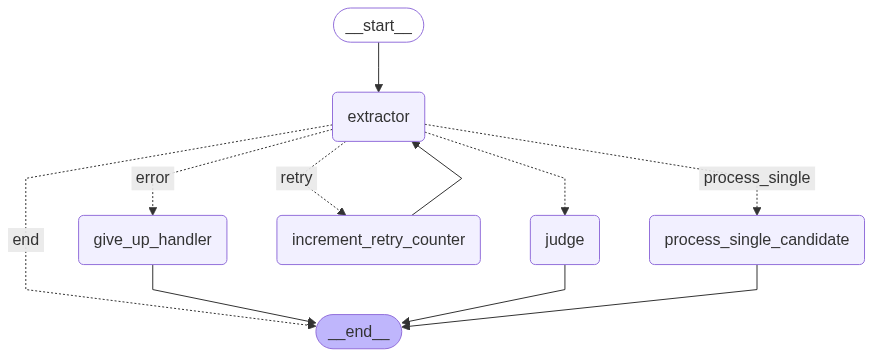

In [ ]:
# 1. Install the underlying system dependency, Graphviz, AND its development headers.
# This is the key step to prevent the pygraphviz installation from failing.
print("Installing Graphviz system dependencies...")
!apt-get install -y graphviz graphviz-dev

# 2. Now, install the Python wrapper library.
print("Installing pygraphviz Python library...")
!pip install -q pygraphviz

from IPython.display import Image, display

# 3. Generate and display the graph visualization.
print("Generating graph visualization...")
try:
    png_data = graph.get_graph().draw_mermaid_png()
    display(Image(png_data))
except Exception as e:
    # If there's still an error, provide the text fallback.
    print(f"Error generating visualization: {e}")
    print("\n--- ASCII Fallback Visualization ---")
    graph.get_graph().print_ascii()

## 5: Execution and Results

This is the main execution block of the notebook. It brings together all the preceding components to process the data and generate results. The process is broken down into clear, sequential steps:

1.  **Data Gathering:** Queries the loaded Text-Fabric data to find all instances of the search terms within paragraphs, creating a list of `match_nodes` to be processed.
2.  **State Initialization:** Creates a list of simple initial states, with each state containing just the `match_node` ID for one of the hits found.
3.  **Pipeline Invocation:** Iterates through the list of initial states and calls the compiled LangGraph pipeline (`graph.invoke()`) for each one.
4.  **Result Categorization & Summary:** Inspects the final state of each run to categorize the outcome and prints a final summary.

---
> **Future Implementation Note: Fine-Tuning Expert Models**
>
> The verified data produced by this pipeline is the ideal source material for the next major phase of this project: **fine-tuning specialized expert models using LoRA adapters**.
>
> 1.  **Create "Golden" Datasets:** We can use the outputs of this pipeline, combined with human verification, to create high-quality datasets for specific skills (e.g., a gazetteer expert trained on the GLOBALISE places data, a commodity expert, a polity expert).
> 2.  **Specialized Fine-Tuned Models:** The data generated and verified by this pipeline is the perfect source material for fine-tuning a smaller, faster, and more accurate "expert" model for this specific task using PEFT/LoRA adapters.
> 3.  **Evaluate Performance:** A critical part of this process would be creating rigorous test cases to quantitatively evaluate the performance of these new adapters against the original baseline model, ensuring that each new "expert" represents a measurable improvement.



###5.1: Data Gathering & State Initialization

This code block performs the initial data preparation for the experiment. First, it queries the loaded Text-Fabric data to find all instances of the defined `search_terms` that occur within a paragraph, creating a comprehensive list of `match_nodes` to be processed. Next, it prepares a list of simple initial states for the pipeline. Each state contains only the unique `match_node` ID, which is all that's required to kick off a run in our new Text-Fabric-driven architecture.

In [ ]:
# 1. Gather all match nodes from Text-Fabric that are within a paragraph.
print("Searching for matches within paragraphs in Text-Fabric data...")
match_nodes = []
search_terms = ["brief", "missive"]

for para_node in F.otype.s('para'):
    words_in_para = L.d(para_node, otype='word')
    for word_node in words_in_para:
        word_text = F.trans.v(word_node)
        if word_text and word_text.lower() in search_terms:
            match_nodes.append(word_node)

print(f"Found {len(match_nodes)} total instances of the search terms within paragraphs.")

# 2. Build the initial states for the graph.
# Each state starts with just the unique node ID for a match.
# Change the slice `[:10]` to process a different number of hits.
test_states = []
for node in match_nodes[2:3]:
    test_states.append({
        "match_node": node,
        "extracted_outputs": [],
        "final_output": None,
        "judge_decision": None,
        "needs_review": False,
        "error": None,
        "retry_count": 0,
    })

print(f"Prepared {len(test_states)} initial states for pipeline execution.")
print(test_states[0])

Searching for matches within paragraphs in Text-Fabric data...
Found 2378 total instances of the search terms within paragraphs.
Prepared 1 initial states for pipeline execution.
{'match_node': 16365, 'extracted_outputs': [], 'final_output': None, 'judge_decision': None, 'needs_review': False, 'error': None, 'retry_count': 0}


###5.2: Pipeline Invocation and Result Collection

This is the main execution loop of the notebook. It iterates through each `init_state` prepared in the previous step and invokes the compiled LangGraph pipeline. A `try...except` block is used to ensure that any critical failure during a single graph run is caught gracefully without stopping the entire process. After each run, the final state of the graph is inspected, and the result is categorized and appended to the appropriate list (`valid_refs`, `invalid_refs`, etc.) for later analysis.

In [ ]:
# Initialize lists to hold the final categorized results.
valid_refs = []
invalid_refs = []
needs_human_review = []
failed_cases = []

print("\n--- Starting Pipeline Execution ---")

# Loop through each initial state and run the compiled graph.
for i, init_state in enumerate(test_states, 1):
    match_node_id = init_state['match_node']
    print(f"\n==================[TEST CASE {i}] Processing match_node: {match_node_id}==================")

    # We create a configuration dictionary for this specific run.
    # This data will be sent to LangSmith.
    config = {
        "configurable": {
            # This sets a clear, dynamic name for the trace in the LangSmith UI.
            "run_name": f"Ref. Val. for Node {match_node_id}",
        },
        # This adds key-value data to your run, which you can see in the "Metadata" tab.
        "metadata": {
            "source_node_id": match_node_id,
            "is_dummy_run": not USE_REAL_LLM,
        }
    }

    try:
        # Invoke the graph with the initial state.
        output = graph.invoke(init_state, config=config)

        # Categorize the result based on the final state.
        if output.get("needs_review") or output.get("error"):
            print(f"  ➔ NEEDS HUMAN REVIEW (Reason: {output.get('error', 'Low confidence or judge conflict')})")
            needs_human_review.append(match_node_id)
        elif output.get("final_output"):
            final_obj = output["final_output"]
            if final_obj.status == "validated":
                print(f"  ➔ VALID reference (High-confidence pass or Judge validated)")
                valid_refs.append(match_node_id)
            elif final_obj.status == "rejected":
                print(f"  ➔ INVALID reference (High-confidence pass or Judge validated)")
                invalid_refs.append(match_node_id)
            else: # "potential" or other statuses
                print(f"  ➔ NEEDS HUMAN REVIEW (Status is '{final_obj.status}')")
                needs_human_review.append(match_nodes)
        else:
            # This case handles if the graph ends without a final_output or an error flag.
            print("  ➔ FAILED CASE (No final output)")
            failed_cases.append(match_node_id)

    except Exception as e:
        # Catch any critical crashes during the graph execution.
        failed_cases.append(f"node: {match_node_id}")
        print(f"  ➔ CRITICAL ERROR: {e}")

print("\n--- Pipeline Execution Complete ---")

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



--- Starting Pipeline Execution ---

==================[TEST CASE 1] Processing match_node: 16365==================

========== ENTERING NODE: reference_validator (Attempt #1) ==========
Processing Match Node: 16365
--- Step 1: Text-Fabric data fetching successful. ---

--- This is the first attempt. Using the STANDARD prompt template. ---
--- Step 2: Prompt string built successfully. ---

--- Step 3: About to call the LLM... ---


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


--- Step 3: LLM call complete. ---

--- Raw LLM Output ---
' Do not include any text, explanation, or markdown formatting before or after the JSON object. 

```json
{
  "reference_text": "brief",
  "reasoning": "The term 'brief' is used in the context of a letter, which is a common document type in the VOC archives. The author, Gerard Reynst, is writing from Bantam and mentions that he has prepared a letter (brief) as a kind of diary. This suggests that the 'brief' is a document that Reynst has written, likely as a report or summary of his experiences. The context implies that the 'brief' is a distinct document, possibly a report or a letter to the Heren Zeventien. The use of the term 'brief' in this context, combined with the mention of writing a letter as a diary, suggests that the 'brief' is a document that Reynst has prepared, likely as a summary or report of his experiences in Bantam. The fact that Reynst mentions that he has prepared a letter as a diary implies that the 'brief' i

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


--- Step 3: LLM call complete. ---

--- Raw LLM Output ---
''
[parser] Total valid extractions: 0

--- Final state update to be returned: ---
{'error': None, 'extracted_outputs': []}
--- Routing decision ---
--> Retrying... (Attempt 2)

========== ENTERING NODE: reference_validator (Attempt #3) ==========
Processing Match Node: 16365
--- Step 1: Text-Fabric data fetching successful. ---

--- This is a retry attempt. Using CONCISE prompt and MINIMAL fields. ---
--- Step 2: Prompt string built successfully. ---

--- Step 3: About to call the LLM... ---
--- Step 3: LLM call complete. ---

--- Raw LLM Output ---
''
[parser] Total valid extractions: 0

--- Final state update to be returned: ---
{'error': None, 'extracted_outputs': []}
--- Routing decision ---
--> No valid candidates after all retries. Ending.
  ➔ FAILED CASE (No final output)

--- Pipeline Execution Complete ---


###5.3: Summary of Results

This final cell aggregates the results collected during the pipeline execution and presents them in a clean, human-readable summary. It provides a quantitative overview of the pipeline's performance, showing the total counts for each category. It also prints the full lists of node IDs for each category, allowing for easy inspection and follow-up analysis of specific cases.

In [ ]:
print("\n===== FINAL SUMMARY =====")
print(f"Total Cases Processed: {len(test_states)}")
print("-" * 25)
print(f"VALID references:       {len(valid_refs)}")
print(f"INVALID references:     {len(invalid_refs)}")
print(f"Needs Human Review:     {len(needs_human_review)}")
print(f"FAILED (Critical Error):  {len(failed_cases)}")
print("-" * 25)

# Optionally print the full lists for inspection
print("\nVALID list:      ", valid_refs)
print("INVALID list:    ", invalid_refs)
print("REVIEW list:     ", needs_human_review)
print("FAILED list:     ", failed_cases)


===== FINAL SUMMARY =====
Total Cases Processed: 1
-------------------------
VALID references:       0
INVALID references:     0
Needs Human Review:     0
FAILED (Critical Error):  1
-------------------------

VALID list:       []
INVALID list:     []
REVIEW list:      []
FAILED list:      [16365]
